### 데이터 로딩 및 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image  # 주피터 노트북에 이미지 삽입
import seaborn as sns
import matplotlib.ticker as ticker # plt 축의 tik(눈금, 틱) 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('Data/diabetes.csv')
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


* Pregnancies : 임신횟수  
* Glucose : 경구 포도당 내성검사 2시간 혈장 포도당 농도 (140미만 정상, 140-199 내당능장애, 200이상 당뇨병)
* BloodPressure : 이완기 혈압 (mmHg)
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값 (mm)
* Insulin : 2시간 혈청 인슐린(mu U/mL)
* BMI : 체질량지수(체중(kg) / 키(cm)^2)
* DiabetesPedigreeFunction : 당뇨 직계 가족력
* Age : 나이
* Outcome : 5년이내 당뇨병 발병여부 (0 또는 1)    

### 머신러닝 완벽 가이드 동영상 캡쳐 자료 (권철민 저)
<img src="img/ml_process.png" width="800" height="600">

### 데이터 전처리 
* pima_1preprocessing참조
* 0값 대체, 통계상은 이상치는 pima indians에게 발생할 수 있어 그대로 두었음
    + logistic regression 이진분류 모델이기 때문에 
    + 다중회귀에서 중요한 정규성, 독립성(다중공선성), 등분산성을 특별히 고려하지 않아도 될 것으로 판단
    + 하지만 입력데이터는 scalier통해 입력, target class 이항분포 확인(범주형일경우 encoding(레이블,OHe))

<Figure size 288x288 with 0 Axes>

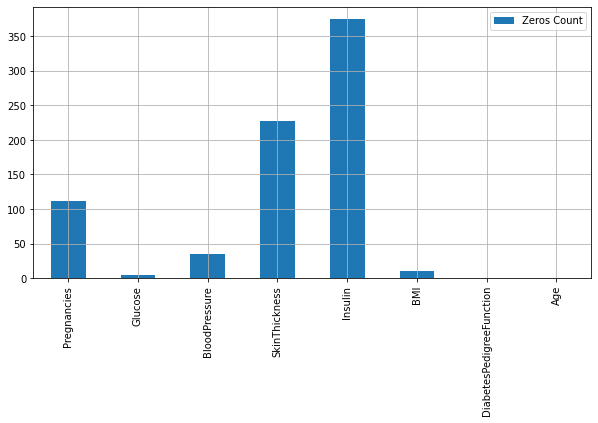

In [5]:
# 0값의 분포
z=(df == 0).sum(axis=0)
z=pd.DataFrame(z)
# print(z.head(10))
z.columns=['Zeros Count']
# print(z.head(10))
z.drop('Outcome',inplace=True)
plt.figure(figsize=(4,4))
z.plot(kind='bar',stacked=True, figsize=(10,5),grid=True)

In [6]:
#0 제거 후 nan 으로 변환 # np.nan의 type : float
col=['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI' ]
for i in col:
    df[i].replace(0, np.nan, inplace= True)

In [7]:
# median 중앙값 찾기
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp
# o값 대체 NaN 채워넣기 
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose')[ median_target('Glucose')['Outcome']==0]['Glucose'].values[0]
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose')[ median_target('Glucose')['Outcome']==1]['Glucose'].values[0]
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure')[ median_target('BloodPressure')['Outcome']==0]['BloodPressure'].values[0]
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure')[ median_target('BloodPressure')['Outcome']==1]['BloodPressure'].values[0]
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness')[ median_target('SkinThickness')['Outcome']==0]['SkinThickness'].values[0]
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness')[ median_target('SkinThickness')['Outcome']==1]['SkinThickness'].values[0]
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] =  median_target('Insulin')[ median_target('Insulin')['Outcome']==0]['Insulin'].values[0]
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = median_target('Insulin')[ median_target('Insulin')['Outcome']==1]['Insulin'].values[0]
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI')[ median_target('BMI')['Outcome']==0]['BMI'].values[0]
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI')[ median_target('BMI')['Outcome']==1]['BMI'].values[0]

In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
## feature 추출, 선택 및 가공
* 통계기반 statsmodels 통해 feature 추출
    + 다중회귀에서 1. 전체모형, 2. 개별 독립변수에 대한 판단 3. 모형의 타당성 검증으로 
    + logit(logistic regression)에서는 개별 독립변수의 유의성 확인
* 엔트로피 기반  entropy : 결정트리사용하는 모든 분류기(classifier) 모델 
    + 독립변수 <-> 종속변수간 엔트로피 직접 계산(mushroom)
    + 분류에서 훈련된 모델에 대해 feature_importances_라는 parameter통해 feature별 모델에 대한 영향력 확인가능  

### estimator 
#### 회귀
+ 단순회귀
+ 다중회귀
#### 분류
+ Logistic regression : 독립변수와 종속변수간 선형관계성 기반
+ 나이브베이즈 : 베이즈통계기반
+ SVM(Support Vetcor Machine) : 개별클래스간 최대 분류 마진을 효과적으로 찾아줌
+ KNN: 근접거리를 기준으로 최소근접 알고리즘
+ 결정트리(Decision Tree) 기반

In [ ]:
### 결정트리 사용하는 분류기(classifier) 모델 
- 결정트리 : CART(분류와 회귀에 동시 사용 가능)
- 앙상블(Ensemble : 다수 weak learner) : 대부분 CART(분류와 회귀에 동시 사용 가능)
    + 보팅방식
    + 배깅방식(랜덤포레스트 : 부트스트랩 도입)
    + 부스팅방식
        - AdaBoost : 가중치 도입
        - GBM : 가중치에 경사하강법 도입(오차함수, 가중치 최적화):순차적 실행으로 시간이 많이 소요, 과적합규제(Regularization)
        - xgboost : GBM 단점 개선  
          + 병렬 cpu 속도개선
          + 자체 과적합 규제기능, 결손값 자체처리, 자동 교차검증(CV), Tree Pruning    
        - LightGBM
- 스태킹(Stacking) : 앙상블의 앙상블

In [ ]:
### 데이터 X, y값 설정 ->  스케일링 적용 -> 훈련, 테스트 데이터로 분리  -> 로지스틱 회귀로 학습  -> 예측
* 로지스틱 회귀는 회귀기반 estimator이므로 target class 불균형시 영향을 많이 받음(straty=True) (cf) 회귀예측에서는 target class 정규분포 형성)
* 이진분류에서는 정밀도, 재현율, F1 score, AUC score가 주로 성능평가 지표로 사용
    + 엔트로피를 줄이는 확률? predict_proba
    + cf) 회귀예측에서는 성능평가지표 : 오차(잔차)줄이는 방향 :  MAE, MSE, RMSE, R2score(분산기반)
    + cf) 회귀예측에서의 오차손실(loss,cost)함수 : MSE, RMSE
* 분류 결정 임계값을 조정해 정밀도와 재현율의 수치를 조정할 수 있음
* F1 score는 정밀도와 재현율이 어느 한쪽에 치우치지 않을 때 좋은 값을 가짐
* AUC score는 ROC 곡선 밑의 면적을 구한 것으로 1에 가까울 수록 좋은 수치
* 이진분류기(estimator)를 분류나 회귀에서 사용할 경우 과적합(overfitting)문제가 발생할 수 있음

#### 데이터 X,y값 설정
* X, y값 분리
* scaling 적용
* 데이터 분리시 target class stratify=y 적용

#### 데이터 분리시 kfold, StratifiedKFold 할 것인가 결정
* kfold  : feature(X값) 데이터를 섞어서 사용
* StratifiedKFold : target(y==class==label)값의 분포가 불균일할 때 
* train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)
    + stratify=y ===> StratifiedKFold 할 것인가 결정한 것임

In [11]:
# 데이터 X, y값 분리
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

# 데이터 훈련, 검증데이터로 분리  # target class의 불균형 제거 stratify=y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

#### estimator (모델) 선정 훈련, 필요시 저장

In [12]:
# 로지스틱 회귀로 학습, 모델링 완료
# 모델선택 : 이진분류기로 LogisticRegression()
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)

# 필요시 모델 저장
# pickle.dump(lr_clf, open('static/modeling/pima.sav', 'wb'))

LogisticRegression()

#### 성능평가지표 조정 필요
* predict()함수는 predict_proba 함수 토대로 만들었음

In [13]:
pred_proba = lr_clf.predict_proba(X_test) # 예측 확률 array에 대한 negative, positive 확률 반환
pred  = lr_clf.predict(X_test)            # positive 확률을 선택해서 임계값보다 높으면 1, 낮으면 0을 반환
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (154, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.96714017 0.03285983]
 [0.81541405 0.18458595]
 [0.91944083 0.08055917]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.96714017 0.03285983 0.        ]
 [0.81541405 0.18458595 0.        ]
 [0.91944083 0.08055917 0.        ]]


<img src="img/threshold.png" width="600" height="400">

#### 성능평가지표 종합함수

In [17]:
def get_clf_eval(y_test=None, pred=None, pred_proba=None): # 권철민 저 책자에 누락 pred_proba
    metric_lst=[]
    confusion = confusion_matrix( y_test, pred)
    metric_lst.append(confusion)
    accuracy = accuracy_score(y_test , pred)
    metric_lst.append(accuracy)
    precision = precision_score(y_test , pred)
    metric_lst.append(precision)
    recall = recall_score(y_test , pred)
    metric_lst.append(recall)
    f1 = f1_score(y_test,pred)
    metric_lst.append(f1)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba) # 권철민 저 책자에 오기 pred --> pred_proba
    metric_lst.append(roc_auc)
    
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    # print(metric_lst)
    return metric_lst

# get_clf_eval(y_test , pred, pred_proba )

#### 데이터 Cross Validation ==>  StratifiedKFold 적용 참고

In [18]:
# from sklearn.model_selection import StratifiedKFold
# skfold = StratifiedKFold(n_splits=3)

# # StratifiedKFold의 split( ) 호출시 반드시 레이블 데이터 셋도 추가 입력 필요  
# for train_index, test_index  in skfold.split(X_scaled, y):
#     # split( )으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
#     X_train, X_test = X_scaled[train_index],X_scaled[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     # 학습 및 예측 
#     lr_clf.fit(X_train , y_train)
#     pred = lr_clf.predict(X_test)
#     pred_proba = lr_clf.predict_proba(X_test)[:,1]
    
#     get_clf_eval(y_test , pred, pred_proba )
#     print('#'*30)  

#### default 임계값(throehold=0.5) 조정해서 분류 임계값을 변경하면서 평가 metrics 측정, 최적 임계값 선택

In [21]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    metrics_dict={}
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1) # predict 수행한 것
        print('임곗값:',custom_threshold)
        
        metric_lst = get_clf_eval(y_test , custom_predict, pred_proba_c1)
        metrics_dict[custom_threshold] = metric_lst

    return metrics_dict
                
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
metrics_dict = get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )
# print(metrics_dict)

# 최적의 임계값 선택
f1_lst=[]
for _, metric in metrics_dict.items():
    f1_lst.append(metric[4])  
# print(f1_lst)
custom_threshold = thresholds[f1_lst.index(max(f1_lst))]
print('#'*30)
print(f'custom_threshold : {custom_threshold}')
print('#'*30)

# 최적 임계값으로 설정한 Binarizer 생성 # 원래 default 임계값 0.5
binarizer = Binarizer(threshold=custom_threshold)
pred_custom_th = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

# 
get_clf_eval(y_test, pred_custom_th, pred_proba[:,1])


임곗값: 0.3
오차 행렬
[[74 26]
 [ 7 47]]
정확도: 0.7857, 정밀도: 0.6438, 재현율: 0.8704,    F1: 0.7402, AUC:0.8893
임곗값: 0.33
오차 행렬
[[81 19]
 [ 8 46]]
정확도: 0.8247, 정밀도: 0.7077, 재현율: 0.8519,    F1: 0.7731, AUC:0.8893
임곗값: 0.36
오차 행렬
[[83 17]
 [ 9 45]]
정확도: 0.8312, 정밀도: 0.7258, 재현율: 0.8333,    F1: 0.7759, AUC:0.8893
임곗값: 0.39
오차 행렬
[[85 15]
 [11 43]]
정확도: 0.8312, 정밀도: 0.7414, 재현율: 0.7963,    F1: 0.7679, AUC:0.8893
임곗값: 0.42
오차 행렬
[[85 15]
 [13 41]]
정확도: 0.8182, 정밀도: 0.7321, 재현율: 0.7593,    F1: 0.7455, AUC:0.8893
임곗값: 0.45
오차 행렬
[[86 14]
 [13 41]]
정확도: 0.8247, 정밀도: 0.7455, 재현율: 0.7593,    F1: 0.7523, AUC:0.8893
임곗값: 0.48
오차 행렬
[[88 12]
 [15 39]]
정확도: 0.8247, 정밀도: 0.7647, 재현율: 0.7222,    F1: 0.7429, AUC:0.8893
임곗값: 0.5
오차 행렬
[[90 10]
 [15 39]]
정확도: 0.8377, 정밀도: 0.7959, 재현율: 0.7222,    F1: 0.7573, AUC:0.8893
##############################
custom_threshold : 0.36
##############################
오차 행렬
[[83 17]
 [ 9 45]]
정확도: 0.8312, 정밀도: 0.7258, 재현율: 0.8333,    F1: 0.7759, AUC:0.8893


[array([[83, 17],
        [ 9, 45]], dtype=int64),
 0.8311688311688312,
 0.7258064516129032,
 0.8333333333333334,
 0.7758620689655172,
 0.8892592592592593]

In [ ]:
### 임계값 조정된 것 + StratifiedKFold 적용

In [ ]:
# # 최적 임곗값 설정한 Binarizer 생성 # 원래 default 임계값 0.5
# binarizer = Binarizer(threshold=pred_custom_th)

# from sklearn.model_selection import StratifiedKFold
# skfold = StratifiedKFold(n_splits=3)
# for train_index, test_index  in skfold.split(X_scaled, y):
#     X_train, X_test = X_scaled[train_index],X_scaled[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     lr_clf.fit(X_train , y_train)
    
#     # pred = lr_clf.predict(X_test)

#     pred_proba = lr_clf.predict_proba(X_test)
#     pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 
#     # 위에서 구한 lr_clf의 predict_proba() 1에 해당하는 컬럼값을 Binarizer변환. => predict 수행을 변경한 값
    
#     get_clf_eval(y_test, pred_th_048, pred_proba[:,1])
#     # get_clf_eval(y_test , pred, pred_proba )
#     print('#'*30)  

### 정밀도 - 재현율 trade off 그리기

##### 한글깨짐 관련 (리눅스, 윈도우)
https://github.com/spisokgit/visual_ncia/blob/master/Day1_%ED%95%9C%EA%B8%80%EA%B9%A8%EC%A7%90.ipynb

In [22]:
# 윈도우에서 설정해 주면 되는 부분
import matplotlib as mpl
import matplotlib.font_manager as fm
font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
mpl.rc('font', family=font_name) # ahronbd.ttf

In [26]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('임계값(Threshold value)'); plt.ylabel('정밀도(Precision) 와 재현율(Recall) value')
    plt.legend(); plt.grid()
    plt.title("precison_recall trade off curve")
    # plt.savefig('static/img/precison_recall.png') # 저장시
    plt.show()
    

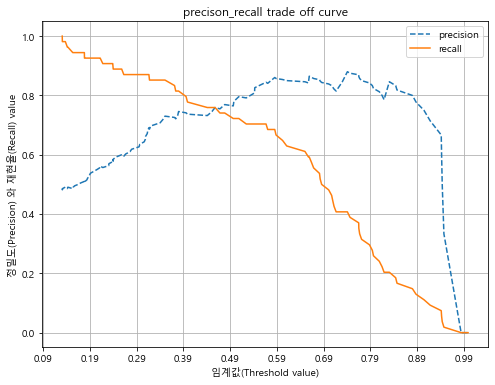

In [27]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

#### ROC curve 그리기,  AUC 구하기

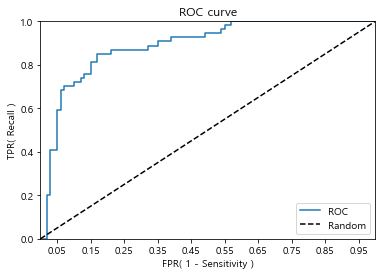

In [28]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.title("ROC curve")
    # plt.savefig('static/img/roc.png') # 저장시
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )